**Rozdelenie na kategorie prichadza v úvahu** 

# Import Python knižníc pre strojové učenie

* **NumPy a Pandas** slúžia na prácu s dátami - NumPy pre matematické operácie a Pandas pre prácu s tabuľkami.

* **Scikit-learn** poskytuje nástroje pre strojové učenie - delenie dát na trénovacie a testovacie množiny (`train_test_split`), hodnotenie modelov (`classification_report`), úpravu dát (`LabelEncoder`, `StandardScaler`) a implementáciu Random Forest algoritmov.

* **Pomocné knižnice** ako `os` pre prácu so súbormi, `joblib` pre ukladanie modelov a konfiguračný súbor definujúci cestu k dátam.

  

In [3]:
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

import joblib
from playstore.config import CLEAN_DATA_DIR

# Načítanie dát z CSV súboru

Kód sa snaží načítať dáta z CSV súboru "cleaned_googleplaystore.csv". Ak sa načítanie nepodarí (napríklad ak súbor neexistuje), vytvorí sa záložný DataFrame s ukážkovými dátami obsahujúci:
- kategóriu aplikácie
- hodnotenie
- typ (platená/bezplatná)
- počet inštalácií

In [8]:
# Load data
try:
    df = pd.read_csv("cleaned_googleplaystore.csv")  # Update to your actual file path if different
    print("Loaded")
except Exception as e:
    print("Error loading data:", e)
    df = pd.DataFrame({
        'Category': ['Game', 'Education', 'Business'],
        'Rating': [4.5, 4.0, 3.8],
        'Type': ['Free', 'Free', 'Paid'],
        'Installs': [1000000, 500000, 100000],
    })


Loaded


# Proces trénovania modelu strojového učenia pre klasifikáciu hodnotení aplikácií

## Step 1: Príprava dát
* Kategórie aplikácií sa prevádzajú na číselné hodnoty pomocou LabelEncoder
* Hodnotenia (Rating) sa kategorizujú do troch skupín:
  - Nízke (0-3.5)
  - Stredné (3.5-4.5) 
  - Vysoké (4.5-5)
______________
* Prečo sa to rozdelovalo do kategorii?
  - Pretože pokial by sme použili na predikovanie RF tak dostaveme hodnoty ktoré sú skreslené a pravdepodobne model je pretrenovaný 0.998..(prediction_1_not_used)- z dvovodu toho že používame rating aj v X premených. 
  - Ak tento rating ostraníme z X prepemných tak sa dostavame k nizkým hodnoma ako je 0.01.. (prediction_2_not_used), čo je veľmi málo pretože Rating je silne zavyslí na Reviews a tým padom jediná premená ktorá ovplyvnuje je Reviews. 
## Step 2: Výber vlastností (features)
* Pre model sa vyberú len relevantné vlastnosti:
  - Počet recenzií (Reviews)
  - Počet inštalácií (Installs)
  - Zakódovaná kategória (Category_encoded) -> 0-32 na numbers (analyza je v dalsich krokoch)

## Step 3: Rozdelenie dát
* Dáta sa rozdelia na trénovaciu (80%) a testovaciu (20%) množinu

## Step 4: Trénovanie modelu
* Použije rozne modely --> dalej je to popisane
* Natrénovaný model sa uloží do súboru 'rf_model_category.pkl'

In [9]:
le_category = LabelEncoder()
df['Category_encoded'] = le_category.fit_transform(df['Category'])
print(df['Category_encoded'])

df['Rating_category'] = pd.cut(
    df['Rating'],
    bins=[0, 3.5, 4.5, 5],
    labels=['Low', 'Medium', 'High']
)
le_rating = LabelEncoder()
df['Rating_encoded'] = le_rating.fit_transform(df['Rating_category'])

# Step 2: 
features = ['Reviews', 'Installs', 'Category_encoded'] 
X = df[features]
y = df['Rating_encoded']

# Step 3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf.fit(X_train, y_train)

joblib.dump(clf, 'rf_model_category.pkl')


0        0
1        0
2        0
3        0
4        0
        ..
8881    11
8882    11
8883    11
8884     3
8885    18
Name: Category_encoded, Length: 8886, dtype: int64


['rf_model_category.pkl']

### Trening s GridSearchCV 
* pre dostanie lepsieho vysledku
* strašne veľa Medium(možno rozdeliť inak)

In [5]:
!pip install imbalanced-learn


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
from imblearn.over_sampling import SMOTE

In [19]:
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report

Best parameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

Train Accuracy: 0.8503095104108047
Test Accuracy: 0.5978627671541057

Classification Report:
              precision    recall  f1-score   support

        High       0.42      0.53      0.47       368
         Low       0.25      0.49      0.33       176
      Medium       0.81      0.63      0.71      1234

    accuracy                           0.60      1778
   macro avg       0.49      0.55      0.50      1778
weighted avg       0.67      0.60      0.62      1778



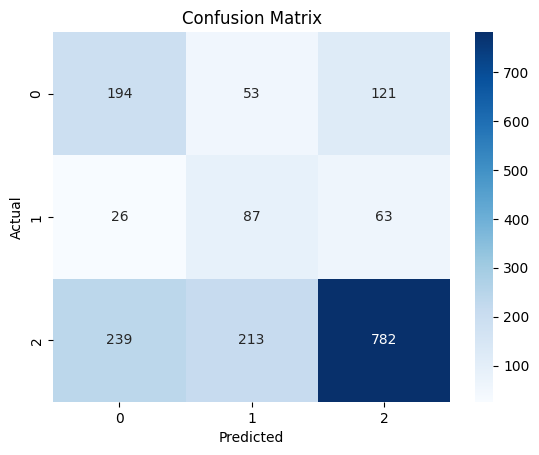

In [57]:
#Preprocessing
le_category = LabelEncoder()
df['Category_encoded'] = le_category.fit_transform(df['Category'])

df['Rating_category'] = pd.cut(
    df['Rating'],
    bins=[0, 3.5, 4.5, 5],
    labels=['Low', 'Medium', 'High']
)

le_rating = LabelEncoder()
df['Rating_encoded'] = le_rating.fit_transform(df['Rating_category'])

df['Log_Reviews'] = np.log1p(df['Reviews'])
df['Log_Installs'] = np.log1p(df['Installs'])

features = ['Log_Reviews', 'Log_Installs', 'Category_encoded']
X = df[features]
y = df['Rating_encoded']

# Step 2:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 3: 

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Potom trénuj model s resamplovanými dátami
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)
clf.fit(X_train_resampled, y_train_resampled)

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train_resampled, y_train_resampled)

clf = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Step 5: 
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

print("\nTrain Accuracy:", accuracy_score(y_train, train_pred))
print("Test Accuracy:", accuracy_score(y_test, test_pred))

print("\nClassification Report:")
print(classification_report(y_test, test_pred, target_names=le_rating.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, clf.predict(X_test))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# # Step 6: Feature Importance
# feature_importances = clf.feature_importances_
# importance_df = pd.DataFrame({
#     'Feature': features,
#     'Importance': feature_importances
# }).sort_values(by='Importance', ascending=False)

# print("\nFeature Importance:")
# print(importance_df)

# # Plot feature importance
# plt.barh(importance_df['Feature'], importance_df['Importance'])
# plt.title("Feature Importances")
# plt.xlabel("Importance")
# plt.ylabel("Feature")
# plt.show()


### Trening s RandomizedSearchCV 
* pre dostanie lepsieho vysledku
* asi najlepši výsledok na train/test data

- Train Accuracy: 0.9739729881823298
- Test Accuracy: 0.7024746906636671

In [11]:
from sklearn.model_selection import RandomizedSearchCV


Train Accuracy: 0.9739729881823298
Test Accuracy: 0.7024746906636671

Classification Report:
              precision    recall  f1-score   support

        High       0.48      0.41      0.44       368
         Low       0.26      0.16      0.20       144
      Medium       0.78      0.85      0.81      1266

    accuracy                           0.70      1778
   macro avg       0.51      0.47      0.49      1778
weighted avg       0.68      0.70      0.69      1778



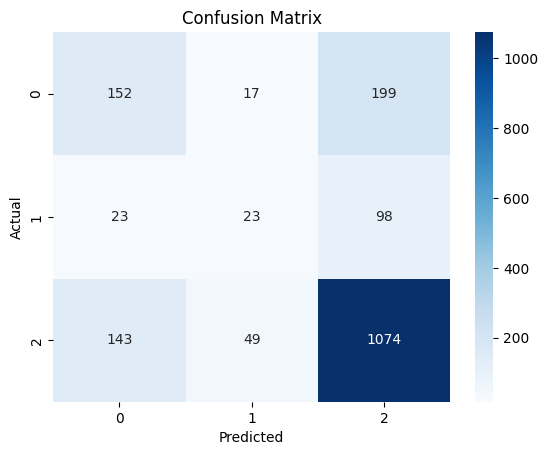

              precision    recall  f1-score   support

         Low       0.48      0.41      0.44       368
      Medium       0.26      0.16      0.20       144
        High       0.78      0.85      0.81      1266

    accuracy                           0.70      1778
   macro avg       0.51      0.47      0.49      1778
weighted avg       0.68      0.70      0.69      1778



In [28]:

# Preprocessing
df['Rating_category'] = df['Rating'].apply(lambda r: 'Low' if r < 3.5 else ('Medium' if r <= 4.5 else 'High'))
le_rating = LabelEncoder()
df['Rating_encoded'] = le_rating.fit_transform(df['Rating_category'])

le_category = LabelEncoder()
df['Category_encoded'] = le_category.fit_transform(df['Category'])

df['Log_Reviews'] = np.log1p(df['Reviews'])
df['Log_Installs'] = np.log1p(df['Installs'])
df['Review_to_Install_Ratio'] = df['Reviews'] / df['Installs']

features = ['Log_Reviews', 'Log_Installs', 'Category_encoded', 'Review_to_Install_Ratio']
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

X = df[features]
y = df['Rating_encoded']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)
clf = random_search.best_estimator_


# Evaluation
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

print("\nTrain Accuracy:", accuracy_score(y_train, train_pred))
print("Test Accuracy:", accuracy_score(y_test, test_pred))
print("\nClassification Report:")
print(classification_report(y_test, test_pred, target_names=le_rating.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, clf.predict(X_test))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Klasifikačný report
print(classification_report(y_test, clf.predict(X_test), target_names=["Low", "Medium", "High"]))

### Trening s RandomForestClassifier s vahamy 
* pre dostanie lepsieho vysledku
* oproti RandomizedSearchCV sa až tak nelíší ale na testovaích o ***1%+***

In [14]:
# Preprocessing
df['Rating_category'] = df['Rating'].apply(lambda r: 'Low' if r < 3.5 else ('Medium' if r <= 4.5 else 'High'))
le_rating = LabelEncoder()
df['Rating_encoded'] = le_rating.fit_transform(df['Rating_category'])

le_category = LabelEncoder()
df['Category_encoded'] = le_category.fit_transform(df['Category'])

df['Log_Reviews'] = np.log1p(df['Reviews'])
df['Log_Installs'] = np.log1p(df['Installs'])
df['Review_to_Install_Ratio'] = df['Reviews'] / df['Installs']

features = ['Log_Reviews', 'Log_Installs', 'Category_encoded', 'Review_to_Install_Ratio']
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

X = df[features]
y = df['Rating_encoded'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

y_train = y_train.astype(int)
y_test = y_test.astype(int)


clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    class_weight={0: 3, 1: 1, 2: 2}, 
    random_state=42
)

# Training
clf.fit(X_train, y_train)

# Evaluation
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

print("\nTrain Accuracy:", accuracy_score(y_train, train_pred))
print("Test Accuracy:", accuracy_score(y_test, test_pred))
print("\nClassification Report:")
print(classification_report(y_test, test_pred, target_names=le_rating.classes_))



Train Accuracy: 0.9582160945413618
Test Accuracy: 0.7165354330708661

Classification Report:
              precision    recall  f1-score   support

        High       0.50      0.39      0.44       368
         Low       0.27      0.09      0.13       144
      Medium       0.78      0.88      0.83      1266

    accuracy                           0.72      1778
   macro avg       0.51      0.45      0.47      1778
weighted avg       0.68      0.72      0.69      1778



## Step 5: Vyhodnotenie modelu
* Vypočíta sa presnosť na trénovacích a testovacích dátach
* Vytvorí sa detailný klasifikačný report

## Step 6: Analýza dôležitosti vlastností
* Vyhodnotí sa, ktoré vlastnosti mali najväčší vplyv na predikciu

## Vyhodnotenie:
* Da sa povedat že pravdepodobnosť na Testovacom modeli 0.70 nie je najlepšie bolo by možne popremýšlať nad zlepšením modelu na hrubý nastrel je to OK.

In [31]:
!pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


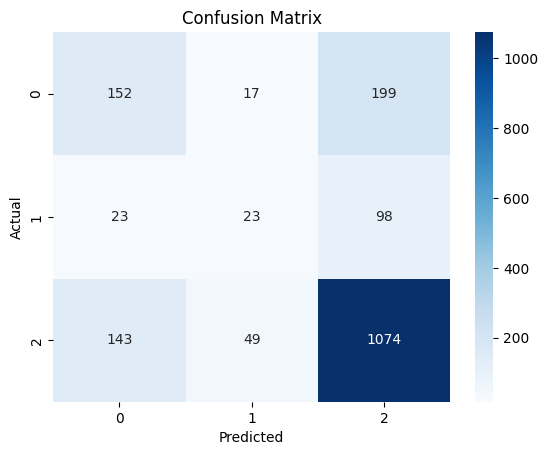

              precision    recall  f1-score   support

         Low       0.48      0.41      0.44       368
      Medium       0.26      0.16      0.20       144
        High       0.78      0.85      0.81      1266

    accuracy                           0.70      1778
   macro avg       0.51      0.47      0.49      1778
weighted avg       0.68      0.70      0.69      1778



In [32]:
from sklearn.metrics import confusion_matrix, classification_report
# Matica zámien
conf_matrix = confusion_matrix(y_test, clf.predict(X_test))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Klasifikačný report
print(classification_report(y_test, clf.predict(X_test), target_names=["Low", "Medium", "High"]))


In [33]:
# Step 5
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)
print("Train Accuracy:", accuracy_score(y_train, train_pred))
print("Test Accuracy:", accuracy_score(y_test, test_pred))
print("\nClassification Report:")
print(classification_report(y_test, test_pred, target_names=le_rating.classes_))

# Step 6
feature_importances = clf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(importance_df)

Train Accuracy: 0.9739729881823298
Test Accuracy: 0.7024746906636671

Classification Report:
              precision    recall  f1-score   support

        High       0.48      0.41      0.44       368
         Low       0.26      0.16      0.20       144
      Medium       0.78      0.85      0.81      1266

    accuracy                           0.70      1778
   macro avg       0.51      0.47      0.49      1778
weighted avg       0.68      0.70      0.69      1778


Feature Importance:
                   Feature  Importance
3  Review_to_Install_Ratio    0.358527
0              Log_Reviews    0.345578
2         Category_encoded    0.223999
1             Log_Installs    0.071896


### Analýza početnosti kategórií

Kód spočíta a zoradí počet aplikácií v jednotlivých zakódovaných kategóriách, čo nám dáva prehľad o distribúcii aplikácií v datasete.

In [ ]:
category_counts = df['Category_encoded'].value_counts().sort_index()
print(category_counts)

# Predikcia hodnotenia pre novú aplikáciu (nezname hodnoty)

Kód predikuje kategóriu hodnotenia pre novú aplikáciu, kde:
1. Vytvorí sa nový DataFrame s vlastnosťami novej aplikácie (recenzie, inštalácie, kategória)
2. Načíta sa uložený model a vykoná predikcia
3. Predikcia sa dekóduje späť z číselnej hodnoty na kategóriu (Nízka/Stredná/Vysoká)

In [21]:
new_data = pd.DataFrame({
    'Reviews': [10],
    'Installs': [500000],
    'Category_encoded': [2]  # Replace with your encoded value for the category
}, columns=features)

# Load the saved model
clf = joblib.load('rf_model_category.pkl')

# Predict the category for the new data
prediction_encoded = clf.predict(new_data)
prediction_decoded = le_rating.inverse_transform(prediction_encoded)

print("\nPrediction for new data:")
print("Encoded Prediction:", prediction_encoded[0])  # Numerical category
print("Decoded Prediction (Rating Category):", prediction_decoded[0])


Prediction for new data:
Encoded Prediction: 2
Decoded Prediction (Rating Category): Medium


# Uloženie natrénovaného modelu

Kód ukladá natrénovaný model pre budúce použitie, pričom:
1. Vytvorí sa cesta k súboru v aktuálnom pracovnom adresári (os.getcwd())
2. Model sa uloží do súboru 'rf_model_category.pkl'
3. Vypíše sa potvrdenie s presnou cestou, kde bol model uložený

Tento krok je dôležitý pre opätovné použitie modelu bez potreby nového trénovania.

In [61]:
model_path = os.path.join(os.getcwd(), "rf_model_category_third.pkl")
joblib.dump(clf, model_path)
print(f"Model saved to {model_path}")

Model saved to /Users/steve/PycharmProjects/uu_school/playstore/notebooks/rf_model_category_third.pkl


### Logistic regresion
* skusit statisticky model na test
  

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Normalizácia dát
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Tréning modelu
clf = LogisticRegression(class_weight='balanced', multi_class='ovr', max_iter=1000)
clf.fit(X_train_scaled, y_train)

# Predikcia
y_pred = clf.predict(X_test_scaled)

# Vyhodnotenie
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[183  79 106]
 [ 24 108  44]
 [269 274 691]]

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.50      0.43       368
           1       0.23      0.61      0.34       176
           2       0.82      0.56      0.67      1234

    accuracy                           0.55      1778
   macro avg       0.48      0.56      0.48      1778
weighted avg       0.67      0.55      0.59      1778



/Users/steve/PycharmProjects/uu_school/playstore/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


### OneVsRest
* skusit statisticky model na test


In [55]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

clf = OneVsRestClassifier(
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
)
clf.fit(X_train, y_train)

# Predikcia
y_pred = clf.predict(X_test)

# Vyhodnotenie
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))




Confusion Matrix:
[[184  78 106]
 [ 25 107  44]
 [271 273 690]]

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.50      0.43       368
           1       0.23      0.61      0.34       176
           2       0.82      0.56      0.67      1234

    accuracy                           0.55      1778
   macro avg       0.48      0.56      0.48      1778
weighted avg       0.67      0.55      0.59      1778

